# Sample APP $-$ INFERENCE

**Objective**

 - load FTS transfer error
 - apply K-Means clustering (two modes):
   - static use of pre-trained model
   - re-training on the new data
   
**Note** The *word2vec* language model is pre-trained once (possible once in a while) and then fixed.

## Spark Session 

In [2]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("sample_app_inference").getOrCreate()
spark

CPU times: user 41.9 ms, sys: 28.9 ms, total: 70.9 ms
Wall time: 7.24 s


## Import data

### **Read from HDFS**

In [2]:
# %%time 

# import pyspark.sql.functions as F
# # 19th October 2019
# day = "2020/03/09"

# # FTS data path
# path_list = ['/project/monitoring/archive/fts/raw/complete/{}/*'.format(day)]
# # path_list = "/project/monitoring/archive/fts/raw/complete/2019/10/18/*"

# # load the data in the json file
# all_transfers = spark.read.json(path_list)

# # retrieve just data
# all_transfers = all_transfers.select("data.*")

# # filter test_errors only
# test_errors = all_transfers.filter(all_transfers["t_final_transfer_state_flag"] == 0)

# # sample 100 random rows
# n = test_errors.count()
# test_errors = test_errors.sample(withReplacement=False, fraction=1.*100/n).limit(100)

# # add row id and select only relevant variables
# test_errors = test_errors.withColumn("msg_id", F.monotonically_increasing_id()).select(
#     "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# # show top 10 rows
# test_errors.toPandas().head(10)

CPU times: user 616 ms, sys: 154 ms, total: 770 ms
Wall time: 2min 9s


,msg_id,t__error_message,src_hostname,dst_hostname,timestamp_tr_comp
0,0,DESTINATION SRM_PUTDONE Error on the surl srm:...,eoscmsftp.cern.ch,srm-cms.cern.ch,1583414544375
1,1,TRANSFER Transfer canceled because the gsiftp...,dcgftp.usatlas.bnl.gov,srm.ndgf.org,0
2,2,TRANSFER ERROR: Copy failed with mode 3rd pus...,golias100.farm.particle.cz,gfe02.grid.hep.ph.ic.ac.uk,1583427213286
3,3,Result (Neon): Could not read status line: con...,lapp-testse01.in2p3.fr,lapp-xdc01.in2p3.fr,0
4,4,TRANSFER ERROR: Copy failed with mode 3rd pul...,lapp-se01.in2p3.fr,lcg-lrz-http.grid.lrz.de,1583400047771
5,5,Result (Neon): Could not read status line: con...,lapp-testse01.in2p3.fr,lapp-xdc01.in2p3.fr,0
6,6,TRANSFER globus_ftp_client: the server respon...,sdrm.t1.grid.kiae.ru,torik1.ulakbim.gov.tr,0
7,7,TRANSFER globus_ftp_client: the server respon...,cmsio.rc.ufl.edu,cmseos-gridftp.fnal.gov,0
8,8,DESTINATION SRM_PUTDONE Error on the surl srm:...,eoscmsftp.cern.ch,srm-cms.cern.ch,1583414700237
9,9,globus_ftp_client: the server responded with a...,eosatlassftp.cern.ch,storm-01.roma3.infn.it,0


#### **Save extracted data as json file**

In [117]:
# test_errors.coalesce(1).write.format('json').mode('overwrite').save('fts_05mar20.json')


### **Alternative: read from json file**

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

test_errors = spark.read.json("sample_app_test_train_ATLAS.json").select(
    "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# visualize data
test_errors.toPandas().head(10)

,msg_id,t__error_message,src_hostname,dst_hostname,timestamp_tr_comp
0,3,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Failed to select pool: No write pools configured outside of a linkgroup.",golias100.farm.particle.cz,lcg-lrz-http.grid.lrz.de,1583776816477
1,5,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Too many attempts to select pool; last pool lunarc_lu_se_103-hep@dc103-hep_lunarc_lu_seDomain failed with Could not create MoverProtocol mover for RemoteHttpsDataTransfer-1.1:https://lcg-se0.ifh.de:2880/pnfs/ifh.de/data/atlas/atlasscratchdisk/rucio/tests/2f/2b/file50_12346754-0b21-487c-95ef-ab612ed25412: directory not found: /etc/grid-security/certificates",lcg-se0.ifh.de,webdav.swegrid.se,1583776817208
2,6,TRANSFER an end-of-file was reached globus_xio: An end of file occurred,gridftp.echo.stfc.ac.uk,se-iep-grid.saske.sk,0
3,7,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 400 : Server Error",lcg-se1.sfu.computecanada.ca,eosatlashttp.cern.ch,1583776819657
4,8,TRANSFER an end-of-file was reached globus_xio: An end of file occurred,golias100.farm.particle.cz,se-iep-grid.saske.sk,0
5,9,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 404 : File not found",tbit00.nipne.ro,gftp01.ncg.ingrid.pt,1583776822740
6,12,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Error string contains not valid UTF-8 chars",agh3.atlas.unimelb.edu.au,tbit00.nipne.ro,1583776823964
7,13,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 403 : Permission refused",golias100.farm.particle.cz,t2-dpm-01.na.infn.it,1583776825819
8,14,Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] Request to [>PnfsManager@local] timed out.,grid002.ft.uam.es,dcsrm.usatlas.bnl.gov,0
9,15,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: SOAP 1.1 fault: SOAP-ENV:Client [no subcode] Detail: connect failed in tcp_connect() .",node12.datagrid.cea.fr,grid-dav.rzg.mpg.de,1583776825635


## Inference 

### Static predictions

In [6]:
# %%time
# import importlib
# import kmeans
# importlib.reload(kmeans)

# test_predictions = kmeans.kmeans_inference(original_data=test_errors, msg_col="t__error_message", id_col="msg_id", 
#                     w2v_model_path="w2v_model", tks_vec="message_vector", ft_col="features",
#                     kmeans_mode="load", kmeans_model_path="best_K_model",
#                     pred_mode="static", new_cluster_thresh=None,# update_model_path=None, #kmeans_predit
#                     distance="cosine", opt_initSteps=10, opt_tol=0.0001, opt_maxIter=30, #K_optim
#                     tr_initSteps=200, tr_tol=0.000001, tr_maxIter=100, #train_kmeans
#                     )

CPU times: user 234 ms, sys: 57.2 ms, total: 291 ms
Wall time: 4.95 s


### Online re-training 

In [10]:
%%time
import kmeans
import importlib
importlib.reload(kmeans)

# setup w2v model path
train_day = "2020-03-19"
data_window = "9-13mar2020"
w2v_path = "results/sample_app/w2v_models/data_window_{}/train_date_{}".format(data_window, train_day)

vs = 100
mc = 100
ws = 8
# "{}/w2v_sample_app_example_VS={}_MC={}_WS={}".format(w2v_path, vs, mc, ws)

n_cores = 1
kmeans_log = """results/sample_app/kmeans_models/inference/
            kmeans_optimization_log_VS={}_MC={}_WS={}_cores={}.txt""".format(vs, mc, ws, n_cores)


test_predictions = kmeans.kmeans_inference(original_data=test_errors, msg_col="t__error_message", id_col="msg_id", 
                    w2v_model_path="{}/w2v_sample_app_example_VS={}_MC={}".format(w2v_path, vs, mc),
                    tks_vec="message_vector", ft_col="features",
                    kmeans_mode="train", kmeans_model_path=None,
                    pred_mode="static", new_cluster_thresh=None,# update_model_path=None, #kmeans_predit
                    distance="cosine", opt_initSteps=30, opt_tol=0.0001, opt_maxIter=30, 
                    log_path=kmeans_log, n_cores=n_cores, #K_optim
                    tr_initSteps=200, tr_tol=0.000001, tr_maxIter=100, #train_kmeans
                    )

Training for K=12
Started at: 2020-03-24 13:51:04


Time elapsed: 4 minutes and 49 seconds.
------------------------------------------------------------
Training for K=16
Started at: 2020-03-24 13:55:53


Time elapsed: 4 minutes and 4 seconds.
------------------------------------------------------------
Training for K=20
Started at: 2020-03-24 13:59:58


Time elapsed: 4 minutes and 59 seconds.
------------------------------------------------------------
CPU times: user 3.27 s, sys: 1.01 s, total: 4.28 s
Wall time: 32min 54s


### K=12

#### Summary

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


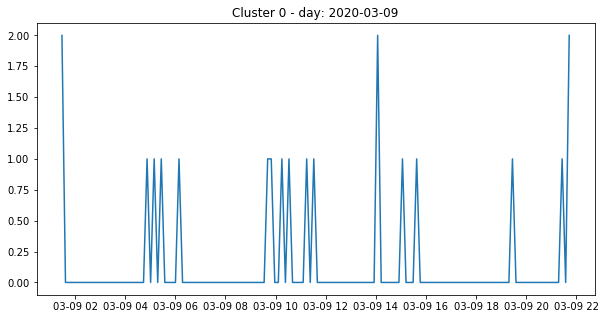

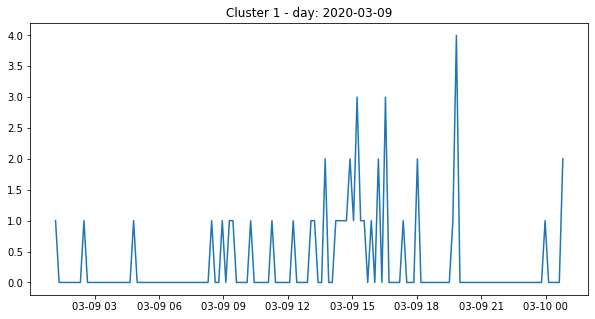

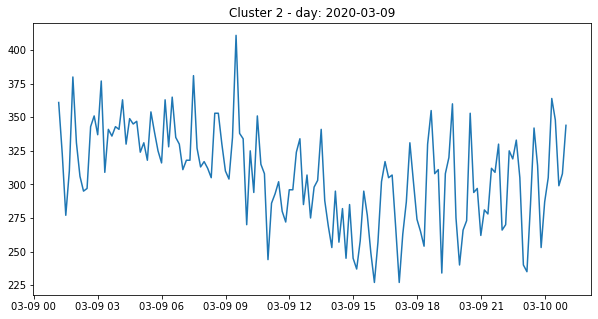

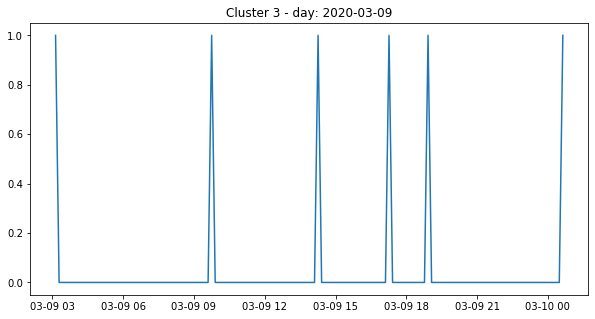

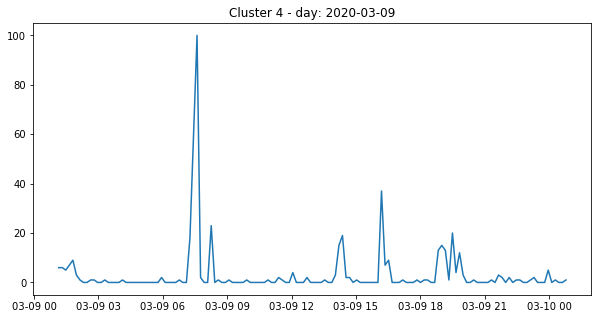

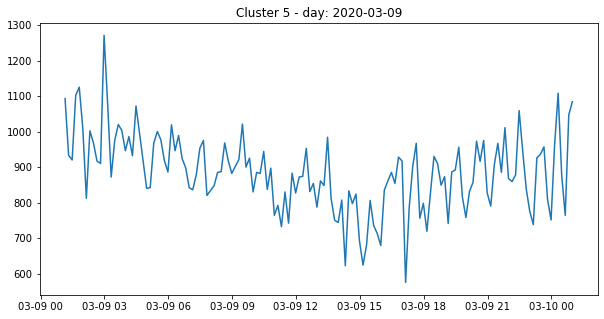

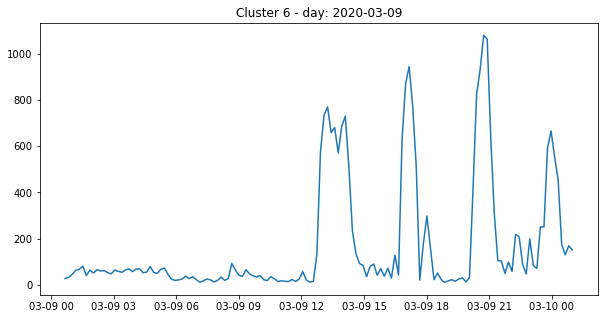

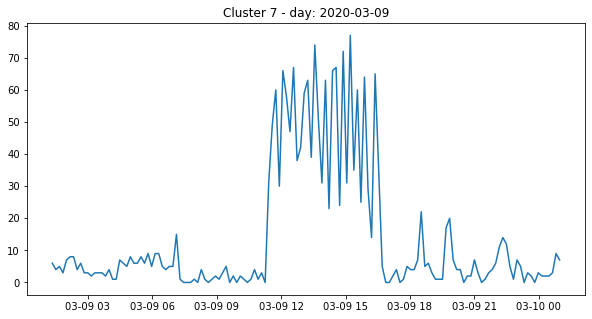

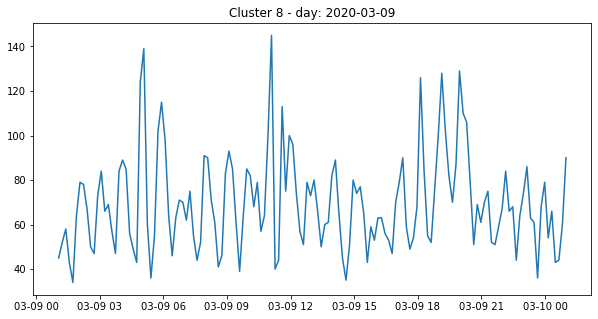

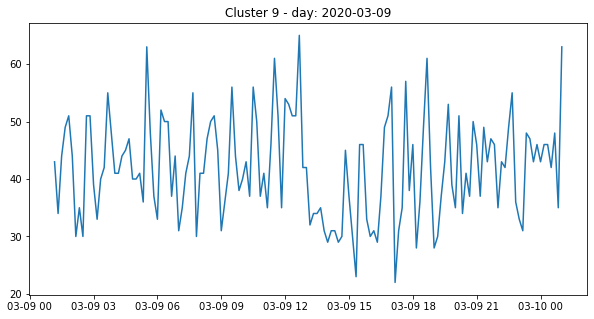

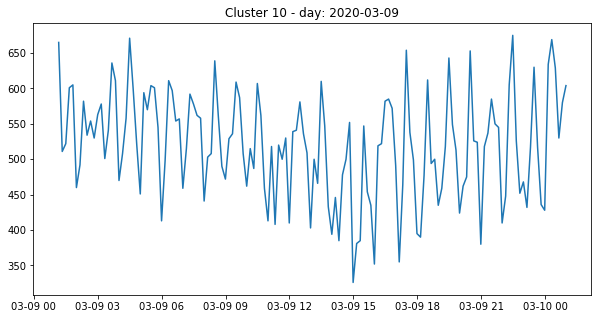

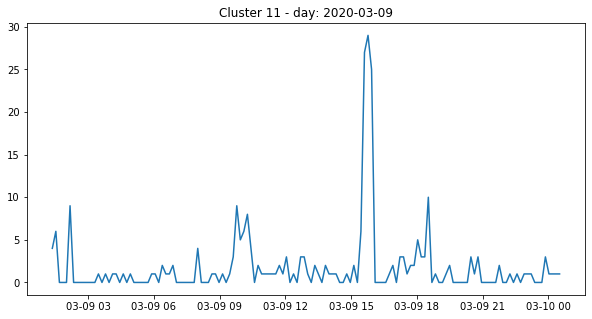

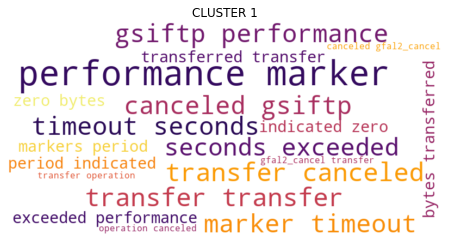

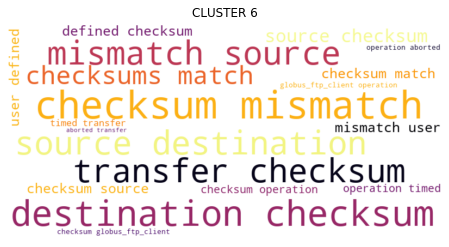

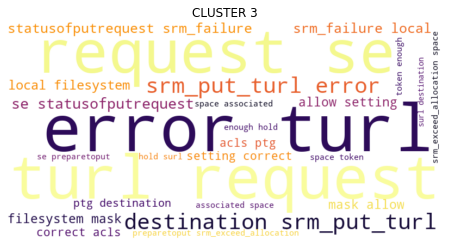

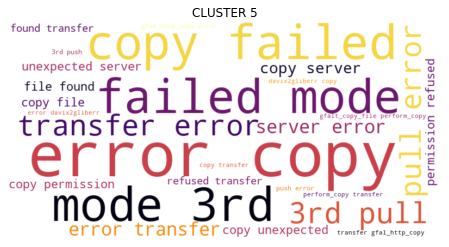

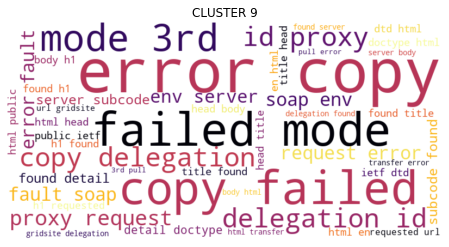

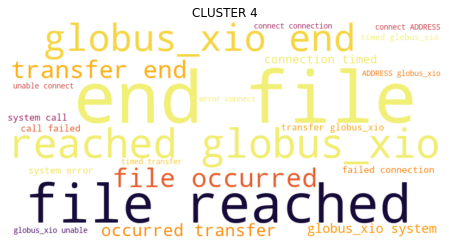

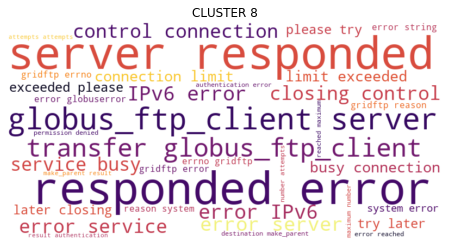

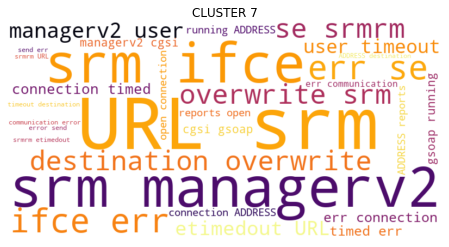

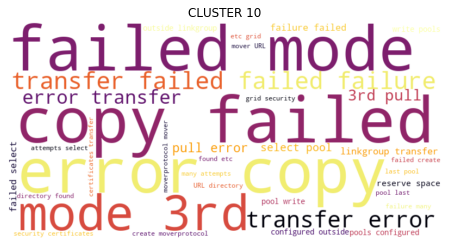

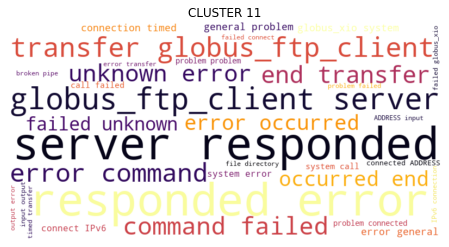

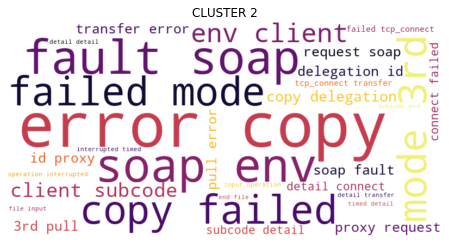

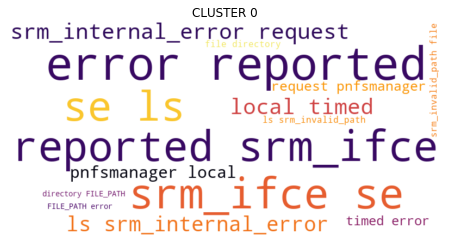

CPU times: user 1min 49s, sys: 7.45 s, total: 1min 57s
Wall time: 1h 37min 39s


,n_messages,unique_strings,unique_patterns,top_5_msg,top_5_src,top_5_dst
prediction,,,,,,
5,127444,127,80,"[{'msg': 'transfer error copy failed with mode 3rd pull with error copy http 400 server error', 'n': 41380, 'n_perc': 0.3247}, {'msg': 'transfer error copy failed with mode 3rd pull with error copy http 500 unexpected server error 500', 'n': 23518, 'n_perc': 0.1845}, {'msg': 'transfer error copy failed with mode 3rd pull with error copy http 404 file not found', 'n': 23489, 'n_perc': 0.1843}, {'msg': 'transfer error copy failed with mode 3rd pull with error copy http 403 permission refused', 'n': 23110, 'n_perc': 0.1813}, {'msg': 'transfer error copy failed with mode 3rd pull with error copy', 'n': 3426, 'n_perc': 0.0269}]","[{'src': 'GRIF', 'n': 8167, 'n_perc': 0.0641}, {'src': 'UKI-SOUTHGRID-OX-HEP', 'n': 6106, 'n_perc': 0.0479}, {'src': 'CERN-PROD', 'n': 4234, 'n_perc': 0.0332}, {'src': 'FR-ALPES', 'n': 3502, 'n_perc': 0.0275}, {'src': 'NCG-INGRID-PT', 'n': 3412, 'n_perc': 0.0268}]","[{'dst': 'CERN-PROD', 'n': 24134, 'n_perc': 0.1894}, {'dst': 'EELA-UTFSM', 'n': 24007, 'n_perc': 0.1884}, {'dst': 'NCG-INGRID-PT', 'n': 23987, 'n_perc': 0.1882}, {'dst': 'INFN-NAPOLI-ATLAS', 'n': 23540, 'n_perc': 0.1847}, {'dst': 'INFN-T1', 'n': 9076, 'n_perc': 0.0712}]"
11,89777,5144,101,"[{'msg': 'transfer globus_ftp_client the server responded with an error 500 500 command failed 500 an unknown error occurred 500 end', 'n': 79454, 'n_perc': 0.885}, {'msg': 'transfer globus_ftp_client the server responded with an error 451 general problem problem while connected to \$ADDRESS input/output error', 'n': 1689, 'n_perc': 0.0188}, {'msg': 'transfer globus_ftp_client the server responded with an error 451 general problem failed to connect \$IPv6 connection timed out', 'n': 1661, 'n_perc': 0.0185}, {'msg': 'transfer globus_ftp_client the server responded with an error 451 internal timeout', 'n': 963, 'n_perc': 0.0107}, {'msg': 'transfer globus_ftp_client the server responded with an error 500 command failed ipc failed while attempting to perform request', 'n': 822, 'n_perc': 0.0092}]","[{'src': 'UKI-NORTHGRID-LANCS-HEP', 'n': 19807, 'n_perc': 0.2206}, {'src': 'UKI-LT2-QMUL', 'n': 19024, 'n_perc': 0.2119}, {'src': 'UKI-NORTHGRID-MAN-HEP', 'n': 18768, 'n_perc': 0.2091}, {'src': 'UKI-LT2-RHUL', 'n': 16030, 'n_perc': 0.1786}, {'src': 'BNL-ATLAS', 'n': 2759, 'n_perc': 0.0307}]","[{'dst': 'UKI-NORTHGRID-LIV-HEP', 'n': 79537, 'n_perc': 0.8859}, {'dst': 'AGLT2', 'n': 1828, 'n_perc': 0.0204}, {'dst': 'RAL-LCG2', 'n': 1264, 'n_perc': 0.0141}, {'dst': 'NDGF-T1', 'n': 1050, 'n_perc': 0.0117}, {'dst': 'BNL-ATLAS', 'n': 997, 'n_perc': 0.0111}]"
10,74899,2113,262,"[{'msg': 'transfer error copy failed with mode 3rd pull with error transfer failed failure failed to select pool no write pools configured outside of a linkgroup', 'n': 23329, 'n_perc': 0.3115}, {'msg': 'transfer error copy failed with mode 3rd pull with error transfer failed failure too many attempts to select pool last pool lunarc_lu_se_103-hep@dc103-hep_lunarc_lu_sedomain failed with could not create moverprotocol mover for \$URL directory not found /etc/grid-security/certificates', 'n': 14214, 'n_perc': 0.1898}, {'msg': 'transfer error copy failed with mode 3rd pull with error transfer failed failure failed to select pool \$ADDRESS unable to reserve space user not authorized to reserve space in any linkgroup', 'n': 14145, 'n_perc': 0.1889}, {'msg': 'transfer error copy failed with mode 3rd pull with error transfer failed failure received fatal alert bad_certificate', 'n': 8180, 'n_perc': 0.1092}, {'msg': 'transfer error copy failed with mode 3rd pull with error transfer failed failure certificate for \$ADDRESS doesnt match any of the subject alternative names \$ADDRESS', 'n': 2855, 'n_perc': 0.0381}]","[{'src': 'CA-SFU-T2', 'n': 6575, 'n_perc': 0.0878}, {'src': 'RRC-KI-T1', 'n': 5670, 'n_perc': 0.0757}, {'src': 'INFN-ROMA1', 'n': 3940, 'n_perc': 0.0526}, {'src': 'Taiwan-LCG2', 'n': 3417, 'n_perc'

In [15]:
%%time

import cluster_visualization
import importlib
importlib.reload(cluster_visualization)

best_k = 12
abs_dataset, summary = cluster_visualization.summary(test_predictions, k=best_k,
                        clust_col="prediction", tks_col="stop_token_1",
                        abs_tks_in="tokens_cleaned", abs_tks_out="abstract_tokens",
                        abstract=True, n_mess=5, wrdcld=True,
                        original=test_errors, src_col="src_hostname", n_src=5,
                        dst_col="dst_hostname", n_dst=5, timeplot=True, time_col="timestamp_tr_comp",
                        save_path="results/sample_app")
    
    
summary

#### Messages 

In [20]:
from termcolor import colored

for clust_id in range(0, best_k):
    cluster = abs_dataset.select("t__error_message").filter(abs_dataset.prediction == clust_id)
    print(colored("Cluster n.{}".format(clust_id), 'red'), "\n")
    for idx, row in enumerate(cluster.head(10)):
        print("{}.".format(idx), row, "\n\n")

Cluster n.0 

0. Row(t__error_message='Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] Request to [>PnfsManager@local] timed out.') 


1. Row(t__error_message='Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] Request to [>PnfsManager@local] timed out.') 


2. Row(t__error_message='Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] Request to [>PnfsManager@local] timed out.') 


3. Row(t__error_message='Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] Request to [>PnfsManager@local] timed out.') 


4. Row(t__error_message='Error reported from srm_ifce : 2 [SE][Ls][SRM_INVALID_PATH] No such file or directory') 


5. Row(t__error_message='Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] Request to [>PnfsManager@local] timed out.') 


6. Row(t__error_message='Error reported from srm_ifce : 70 [SE][Ls][SRM_INTERNAL_ERROR] Request to [>PnfsManager@local] timed out.') 


7. Row(t__error_message='Error reported from srm_ifce 

0. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 500 : Unexpected server error: 500 ') 


1. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 403 : Permission refused ') 


2. Row(t__error_message='[gfalt_copy_file][perform_copy] TRANSFER  [gfal_http_copy] ERROR: Copy failed with mode 3rd push, with error: [davix2gliberr] copy HTTP 500 : Unexpected server error: 500 ') 


3. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 500 : Unexpected server error: 500 ') 


4. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 500 : Unexpected server error: 500 ') 


5. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 403 : Permission refused ') 


6. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 400 : Server Error ') 


7. Row(t__er

0. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Failed to select pool: diskCacheV111.services.space.SpaceAuthorizationException: Unable to reserve space: user not authorized to reserve space in any linkgroup. ') 


1. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Failed to select pool: diskCacheV111.services.space.SpaceAuthorizationException: Unable to reserve space: user not authorized to reserve space in any linkgroup. ') 


2. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Failed to select pool: diskCacheV111.services.space.SpaceAuthorizationException: Unable to reserve space: user not authorized to reserve space in any linkgroup. ') 


3. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Remote copy failed with status code 0: Could not re

### Large Ks search: K=44

In [4]:
%%time
import kmeans
import importlib
importlib.reload(kmeans)

# setup w2v model path
train_day = "2020-03-19"
data_window = "9-13mar2020"
w2v_path = "results/sample_app/w2v_models/data_window_{}/train_date_{}".format(data_window, train_day)

vs = 100
mc = 100
ws = 8
# "{}/w2v_sample_app_example_VS={}_MC={}_WS={}".format(w2v_path, vs, mc, ws)

n_cores = 1
kmeans_log = """results/sample_app/kmeans_models/inference/
            kmeans_optimization_log_VS={}_MC={}_WS={}_cores={}.txt""".format(vs, mc, ws, n_cores)


test_predictions = kmeans.kmeans_inference(original_data=test_errors, msg_col="t__error_message", id_col="msg_id", 
                    w2v_model_path="{}/w2v_sample_app_example_VS={}_MC={}".format(w2v_path, vs, mc),
                    tks_vec="message_vector", ft_col="features",
                    kmeans_mode="train", kmeans_model_path=None,
                    pred_mode="static", new_cluster_thresh=None, k_list=[44],
                    distance="cosine", opt_initSteps=1, opt_tol=1, opt_maxIter=1, 
                    log_path=kmeans_log, n_cores=n_cores, #K_optim
                    tr_initSteps=200, tr_tol=0.0001, tr_maxIter=100, #train_kmeans
                    )

Training for K=44
Started at: 2020-03-26 09:44:37


Time elapsed: 4 minutes and 32 seconds.
------------------------------------------------------------
CPU times: user 5.05 s, sys: 1.32 s, total: 6.38 s
Wall time: 58min 21s


#### Summary

In [ ]:
%%time

import cluster_visualization
import importlib
importlib.reload(cluster_visualization)

best_k = 44
abs_dataset, summary = cluster_visualization.summary(test_predictions, k=best_k,
                        clust_col="prediction", tks_col="stop_token_1",
                        abs_tks_in="tokens_cleaned", abs_tks_out="abstract_tokens",
                        abstract=True, n_mess=5, wrdcld=False,
                        original=test_errors, src_col="src_hostname", n_src=5,
                        dst_col="dst_hostname", n_dst=5, timeplot=False, time_col="timestamp_tr_comp",
                        save_path="results/sample_app/K={}".format(best_k))
    
    
summary

#### Visualization 

#### Messages 

In [7]:
from termcolor import colored

for clust_id in range(0, best_k):
    cluster = abs_dataset.select("t__error_message").filter(abs_dataset.prediction == clust_id)
    print(colored("Cluster n.{}".format(clust_id), 'red'), "\n")
    for idx, row in enumerate(cluster.head(10)):
        print("{}.".format(idx), row, "\n\n")

Cluster n.0 

0. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: SOAP 1.1 fault: SOAP-ENV:Client [no subcode] End of file or no input: Operation interrupted or timed out Detail: [no detail] . ') 


1. Row(t__error_message='TRANSFER  Operation timed out') 


2. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: SOAP 1.1 fault: SOAP-ENV:Client [no subcode] End of file or no input: Operation interrupted or timed out Detail: [no detail] . ') 


3. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: SOAP 1.1 fault: SOAP-ENV:Client [no subcode] End of file or no input: Operation interrupted or timed out Detail: [no detail] . ') 


4. Row(t__error_message='TRANSFER  ERROR: Copy failed with 

0. Row(t__error_message='Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3010] Write permission denied ') 


1. Row(t__error_message='Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3010] Write permission denied ') 


2. Row(t__error_message='Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [3010] Access denied: /pnfs/triumf.ca/data/atlas/atlasscratchdisk/rucio/tests/2b/55/file3_f55bdfd4-0e33-4e70-bccd-8c0596201584 ') 


3. Row(t__error_message='DESTINATION CHECKSUM Error reported from srm_ifce : 13 [SE][Ls][SRM_AUTHORIZATION_FAILURE] Permission denied') 


4. Row(t__error_message='Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [4003] Authentication to lapp-se01.in2p3.fr:1094 failed; all protocols have been tried. ') 


5. Row(t__error_message='Error on XrdCl::CopyProcess::Run(): [ERROR] Server responded with an error: [4003] Authentication to golias100.farm.particle.cz:109

0. Row(t__error_message='SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do not match aa4baccc != 4528df26') 


1. Row(t__error_message='TRANSFER CHECKSUM MISMATCH Source and destination checksums do not match 6cd9e31e != 2ee2b9a3') 


2. Row(t__error_message='TRANSFER CHECKSUM MISMATCH Source and destination checksums do not match 5d8b4d4f != 00000000') 


3. Row(t__error_message='SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do not match 7847ff56 != 6c0f2254') 


4. Row(t__error_message='SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do not match aa4baccc != 4528df26') 


5. Row(t__error_message='SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do not match 1137ceb4 != 1574d6d5') 


6. Row(t__error_message='SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do not match 1137ceb4 != 1574d6d5') 


7. Row(t__error_message='SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do no

0. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: SOAP 1.1 fault: SOAP-ENV:Client [no subcode]  Detail: connect failed in tcp_connect() . ') 


1. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: SOAP 1.1 fault: SOAP-ENV:Client [no subcode]  Detail: connect failed in tcp_connect() . ') 


2. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: SOAP 1.1 fault: SOAP-ENV:Client [no subcode]  Detail: connect failed in tcp_connect() . ') 


3. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: SOAP 1.1 fault: SOAP-ENV:Client [no subcode]  Detail: connect failed in tcp_connect() . ') 




0. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: Error 404 fault: SOAP-ENV:Server [no subcode] HTTP/1.1 404 Not Found Detail: <!DOCTYPE HTML PUBLIC -//IETF//DTD HTML 2.0//EN> <html><head> <title>404 Not Found</title> </head><body> <h1>Not Found</h1> <p>The requested URL /gridsite-delegation was not found on this server.</p> </body></html>  . ') 


1. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: Error 404 fault: SOAP-ENV:Server [no subcode] HTTP/1.1 404 Not Found Detail: <!DOCTYPE HTML PUBLIC -//IETF//DTD HTML 2.0//EN> <html><head> <title>404 Not Found</title> </head><body> <h1>Not Found</h1> <p>The requested URL /gridsite-delegation was not found on this server.</p> </body></html>  . ') 


2. Row(t__error_message='TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: 

## Extra bit: illustration

##### Scatterplot 

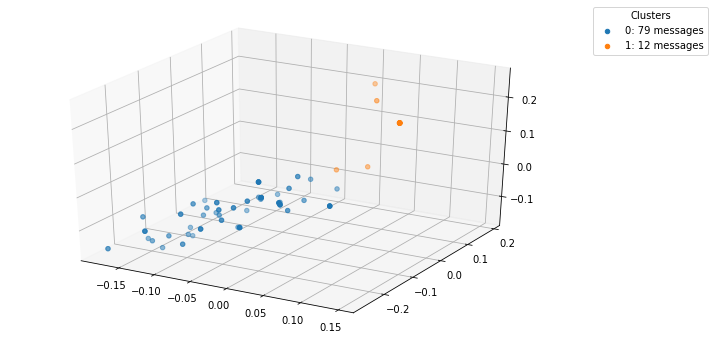

In [13]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
import numpy as np
from kmeans import get_k_best, plot_metrics

data = test_predictions.select("t__error_message", "features", "prediction").toPandas()
k = test_predictions.select("prediction").distinct().count()
df = pd.DataFrame(None, columns=["cluster", "x", "y", "z"])
i=1

for clust_id in range(0, k):
    cluster = data["features"][data.prediction == clust_id]
    for row in cluster:
        x, y, z  = row
        df.loc[i] = [clust_id, x, y, z]
        i += 1 

# Create plot
fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
for clust_id in range(0, k):
    cluster_df = df[df.cluster == clust_id]
    _ = ax.scatter(cluster_df.x, cluster_df.y, cluster_df.z, label="{}: {} messages".format(clust_id, cluster_df.shape[0]) )
_ = ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)